In [186]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
from sklearn.ensemble import RandomForestRegressor
from IPython.core.display import display,HTML
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.tree import DecisionTreeRegressor
import joblib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers


In [187]:
#import xgboost as xgb
from fancyimpute import KNN

In [188]:
#pip install -U numpy 
import numpy as np

In [189]:
import xgboost

In [190]:
#pip install xgboost
from xgboost import XGBRegressor


In [191]:
train=pd.read_csv('https://raw.githubusercontent.com/datascience-enthusiast/Cab-Fare-Prediction/master/train_cab.csv',na_values={'fare_amount':'430-'})
test=pd.read_csv('https://raw.githubusercontent.com/datascience-enthusiast/Cab-Fare-Prediction/master/test.csv')


In [ ]:
#pickup_datetime - timestamp value indicating when the cab ride started.
#pickup_longitude - float for longitude coordinate of where the cab ride started.
#pickup_latitude - float for latitude coordinate of where the cab ride started.
#dropoff_longitude - float for longitude coordinate of where the cab ride ended.
#dropoff_latitude - float for latitude coordinate of where the cab ride ended.
#passenger_count - an integer indicating the number of passengers in the cabride

# Understanding the data

In [192]:
train.shape

(16067, 7)

In [193]:
test.shape

(9914, 6)

In [194]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [195]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [196]:
# as seen from the above 2 datasets we have 6 independent variables and 1 dependent variables in the train dataset and the
#target variable is fare_amount

In [197]:
#now getting info
#train.info(null_counts=True)

In [198]:
train.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [199]:
# converting  pickup datetime to datetime
#train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")

In [200]:
train=train.drop(train[train['pickup_datetime']=='43'].index,axis=0)


In [201]:
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC",errors='coerce')

In [202]:
test.dtypes

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [203]:
test['passenger_count']=test['passenger_count'].astype(float)

In [204]:
train.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count             float64
dtype: object

In [205]:
train['fare_amount']=train['fare_amount'].astype(float)

# Missing Values Analysis

In [206]:
train.isnull().sum()

fare_amount          25
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [207]:
test.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [208]:
train.isnull().sum().sort_values(ascending=False)

passenger_count      55
fare_amount          25
dropoff_latitude      0
dropoff_longitude     0
pickup_latitude       0
pickup_longitude      0
pickup_datetime       0
dtype: int64

In [209]:
train = train.drop(train[train.isnull().any(1)].index, axis = 0)

In [210]:
train.shape

(15986, 7)

In [211]:
train['fare_amount'].describe()

count    15986.000000
mean        15.030453
std        431.213944
min         -3.000000
25%          6.000000
50%          8.500000
75%         12.500000
max      54343.000000
Name: fare_amount, dtype: float64

In [212]:
#we check for any negative values in the fare_amount
from collections import Counter
Counter(train['fare_amount']<=0)

Counter({False: 15982, True: 4})

In [213]:
train = train.drop(train[train['fare_amount']<0].index, axis = 0) #3 observations dropped
train = train.drop(train[train['fare_amount']== 0].index, axis = 0) #1 observations dropped
train.shape

(15982, 7)

In [214]:
train['fare_amount'].describe()

count    15982.000000
mean        15.034740
std        431.267821
min          0.010000
25%          6.000000
50%          8.500000
75%         12.500000
max      54343.000000
Name: fare_amount, dtype: float64

In [215]:
#from this we see that the max value in the fare column in 54343 which doesn't make any sense
train['fare_amount'].sort_values(ascending = False)

1015    54343.00
1072     4343.00
607       453.00
980       434.00
1335      180.00
          ...   
9773        2.50
8603        2.50
8596        2.50
1427        1.14
2780        0.01
Name: fare_amount, Length: 15982, dtype: float64

In [216]:
train=train.drop(train[train['fare_amount']==54343].index,axis=0)
train=train.drop(train[train['fare_amount']==4343].index,axis=0)
#After Checking highest fare_amount, fount that there 3 values which are highest and not possible in fare_amount
train=train.drop(train[train['fare_amount']==0.01].index,axis=0)

In [217]:
train.shape

(15979, 7)

In [218]:
train['passenger_count'].describe()

count    15979.000000
mean         2.623795
std         60.905468
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       5345.000000
Name: passenger_count, dtype: float64

In [219]:
train['passenger_count'].sort_values(ascending=False)

1146     5345.0
293      5334.0
8985      557.0
971       554.0
8506      537.0
          ...  
9965        0.0
3034        0.0
3481        0.0
15919       0.0
11803       0.0
Name: passenger_count, Length: 15979, dtype: float64

In [220]:
train=train.drop(train[train['passenger_count']>10].index,axis=0)


In [221]:
train.shape

(15960, 7)

In [222]:
train['passenger_count'].describe()

count    15960.000000
mean         1.643698
std          1.267422
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

In [223]:
train['passenger_count'].sort_values(ascending=True)

5517     0.0
9965     0.0
12611    0.0
3481     0.0
3034     0.0
        ... 
392      6.0
10361    6.0
13692    6.0
373      6.0
12363    6.0
Name: passenger_count, Length: 15960, dtype: float64

In [224]:
#now deleting the passenger counts which are in 0's and in decimals as these are outliers
train=train.drop(train[train['passenger_count']==0].index,axis=0)


In [225]:
train['passenger_count'].sort_values(ascending=True)

8862     0.12
0        1.00
9797     1.00
9798     1.00
9801     1.00
         ... 
5019     6.00
7455     6.00
10657    6.00
8459     6.00
8881     6.00
Name: passenger_count, Length: 15903, dtype: float64

In [226]:
# we found value 0.12 which is also a outlier dropping it
train=train.drop(train[train['passenger_count']==0.12].index,axis=0)


In [227]:
train['passenger_count'].describe()

count    15902.000000
mean         1.649686
std          1.265840
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

In [228]:
train['pickup_longitude'].describe()

count    15902.000000
mean       -72.474987
std         10.538452
min        -74.438233
25%        -73.992144
50%        -73.981691
75%        -73.966805
max         40.766125
Name: pickup_longitude, dtype: float64

# New York City Latitude and longitude coordinates are: 40.730610, -73.935242.

In [229]:
#Latitude ranges from 39 to 43
#Longitude ranges from -72 to -76
#so dropping all the other regions
train = train.drop(train[train['pickup_latitude']<39].index, axis=0) 

In [230]:
train.shape

(15584, 7)

In [231]:
train = train.drop(train[train['pickup_latitude']>43].index, axis=0)

In [232]:
train.shape

(15583, 7)

In [233]:
train['pickup_latitude'].describe()

count    15583.000000
mean        40.750923
std          0.038016
min         39.603178
25%         40.736592
50%         40.753368
75%         40.767805
max         41.366138
Name: pickup_latitude, dtype: float64

In [234]:
train['pickup_longitude'].describe()

count    15583.000000
mean       -73.974797
std          0.041558
min        -74.438233
25%        -73.992373
50%        -73.982049
75%        -73.968079
max        -73.137393
Name: pickup_longitude, dtype: float64

In [235]:
train = train.drop(train[train['pickup_longitude']>-72].index, axis=0) 

In [236]:
train.shape

(15583, 7)

In [237]:
train = train.drop(train[train['pickup_longitude']<-76].index, axis=0) 

In [238]:
train.shape

(15583, 7)

In [239]:
train['dropoff_latitude'].describe()

count    15583.000000
mean        40.725305
std          1.030963
min          0.000000
25%         40.736300
50%         40.754217
75%         40.768311
max         41.366138
Name: dropoff_latitude, dtype: float64

In [240]:
train = train.drop(train[train['dropoff_latitude']<39].index, axis=0)

In [241]:
train = train.drop(train[train['dropoff_latitude']>43].index, axis=0)

In [242]:
train = train.drop(train[train['dropoff_longitude']>-72].index, axis=0)

In [243]:
train = train.drop(train[train['dropoff_longitude']<-76].index, axis=0)

In [244]:
train.shape

(15570, 7)

# Feature Selection

In [245]:
#correlation matrix to understand how the each variable related with each other
corr=train.corr()
corr

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.298960,-0.131786,0.252538,-0.105001,0.004734
pickup_longitude,0.298960,1.000000,0.196346,0.390560,0.154156,-0.004675
pickup_latitude,-0.131786,0.196346,1.000000,0.158357,0.505780,-0.003151
dropoff_longitude,0.252538,0.390560,0.158357,1.000000,0.260921,-0.007609
dropoff_latitude,-0.105001,0.154156,0.505780,0.260921,1.000000,-0.003112
passenger_count,0.004734,-0.004675,-0.003151,-0.007609,-0.003112,1.000000


C:\Users\lalit\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


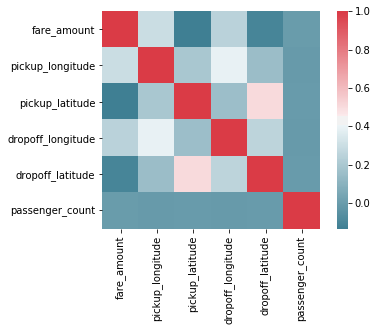

In [246]:
# we see that each variable in dataset is independent and not correlated with each other. So, each variable or feature play an important role to predict the fare_amount
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),cmap = sns.diverging_palette(220,10,as_cmap=True),square =True)

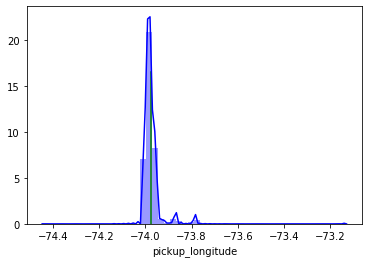

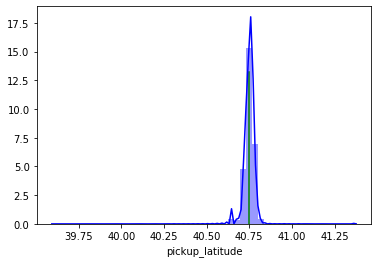

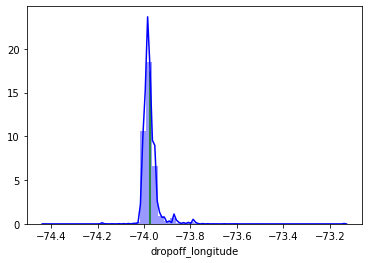

In [247]:
continous_columns=['pickup_longitude','pickup_latitude','dropoff_longitude']
for i,col in enumerate(continous_columns):
    plt.figure(i)
    plt.axvline(train[col].mean(),0,0.7,color='g')
    sns.distplot(train[col],color='b')

C:\Users\lalit\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\lalit\anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


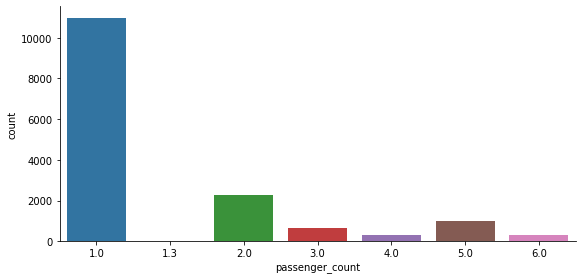

In [248]:
category_columns_names=['passenger_count']
for i in category_columns_names:
    sns.factorplot(data=train,x=i,kind='count',size=4,aspect=2)

Text(0.5, 1.0, 'Histogram for Fare and people')

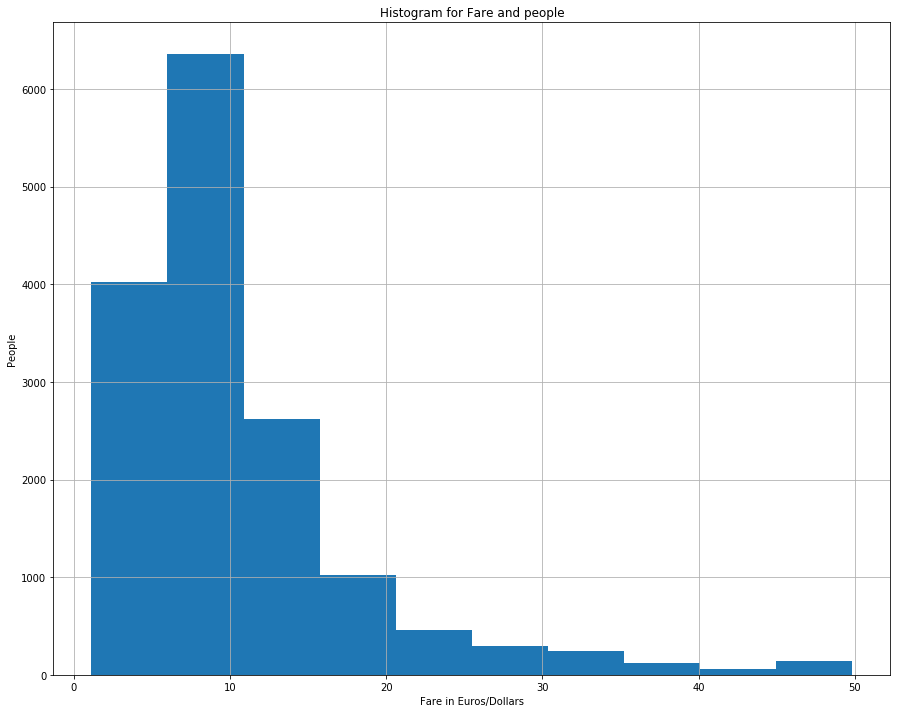

In [249]:
train[train['fare_amount']<50].fare_amount.hist(figsize=(15,12))
plt.xlabel('Fare in Euros/Dollars')
plt.ylabel('People')
plt.title('Histogram for Fare and people')

C:\Users\lalit\anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


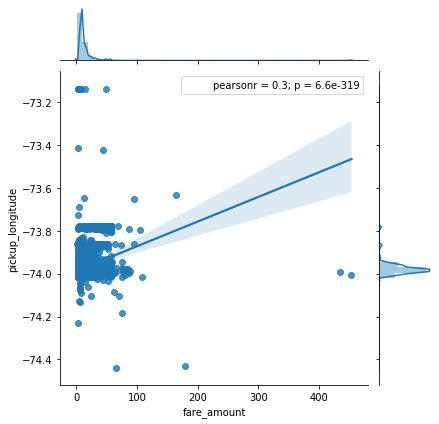

In [250]:
a= sns.jointplot(x='fare_amount',y='pickup_longitude',data=train,kind = 'reg')
a.annotate(stats.pearsonr)
# plt.savefig('jointfplo.png')
plt.show()

C:\Users\lalit\anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


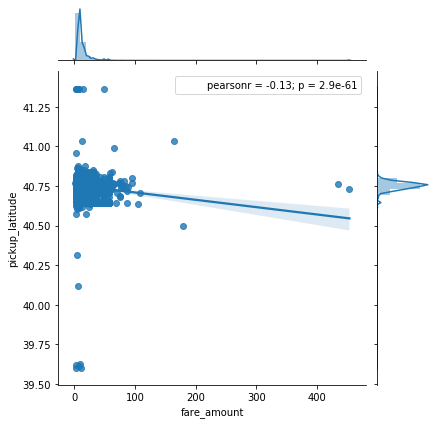

In [251]:
a= sns.jointplot(x='fare_amount',y='pickup_latitude',data=train,kind = 'reg')
a.annotate(stats.pearsonr)
# plt.savefig('jointfpla.png')
plt.show()

C:\Users\lalit\anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


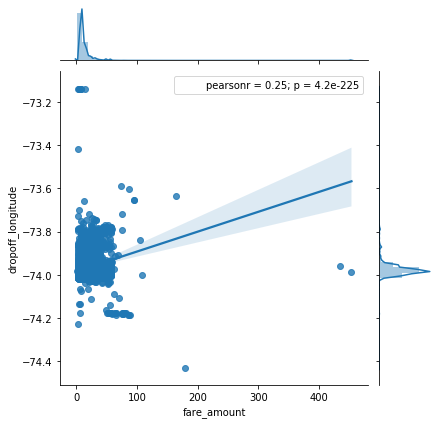

In [252]:
a= sns.jointplot(x='fare_amount',y='dropoff_longitude',data=train,kind = 'reg')
a.annotate(stats.pearsonr)
# plt.savefig('jointfdlo.png')
plt.show()

In [253]:
train.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count             float64
dtype: object

In [254]:
test.dtypes

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [255]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


# Exploratory Data Analysis

In [256]:
#Does the passenger_count (Number of Passengers) affect the fare_amount (fare)?
#Does the pickup_datetime (Pickup Date & Time) affect the fare_amount (fare)?
#Does the day of the week affect the fare_amount (fare)?
#Does the distance travelled affect the fare_amount (fare)?

In [257]:
for i in range(4,11):
    print('passenger count above '+str(i)+'={}'.format(sum(train['passenger_count']>i)))

passenger count above 4=1318
passenger count above 5=294
passenger count above 6=0
passenger count above 7=0
passenger count above 8=0
passenger count above 9=0
passenger count above 10=0


In [258]:
train['pickup_datetime'] = train['pickup_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S UTC')

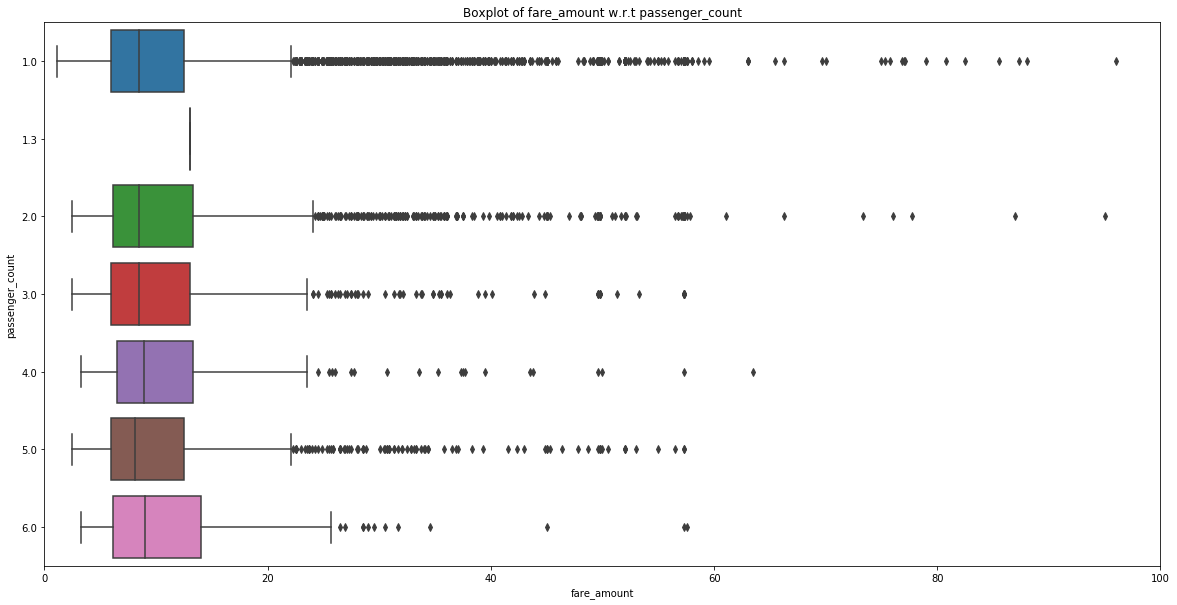

In [259]:
#bivariate analysis
plt.figure(figsize=(20,10))
plt.xlim(0,100)
a= sns.boxplot(x=train['fare_amount'],y=train['passenger_count'],data=train,orient='h')
plt.title('Boxplot of fare_amount w.r.t passenger_count')
# plt.savefig('Boxplot of fare_amount w.r.t passenger_count.png')
plt.show()

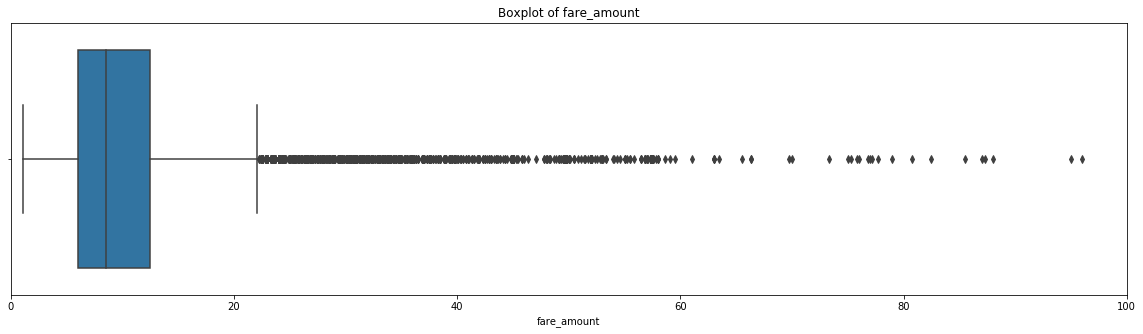

In [260]:
#Univariate Boxplots: Boxplots for all Numerical Variables including target variable

plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['fare_amount'],data=train,orient='h')
plt.title('Boxplot of fare_amount')
# plt.savefig('bp of fare_amount.png')
plt.show()

In [261]:
#how the pickup_location affect the fare_amoun
#we first splitted the dataset into year,month,date,hour
data = [train, test]
#for i in data:
 #   i['Year'] = i ['pickup_datetime'].dt.year
  #  i['Month'] = i ['pickup_datetime'].dt.month
   # i['Date'] = i ['pickup_datetime'].dt.day
   #i['Day_of_week'] = i ['pickup_datetime'].dt.dayofweek
    #i['Hour'] = i ['pickup_datetime'].dt.hour

In [263]:
#Does the passenger_count (Number of Passengers) affect the fare_amount (fare)?

Text(0, 0.5, 'Frequency')

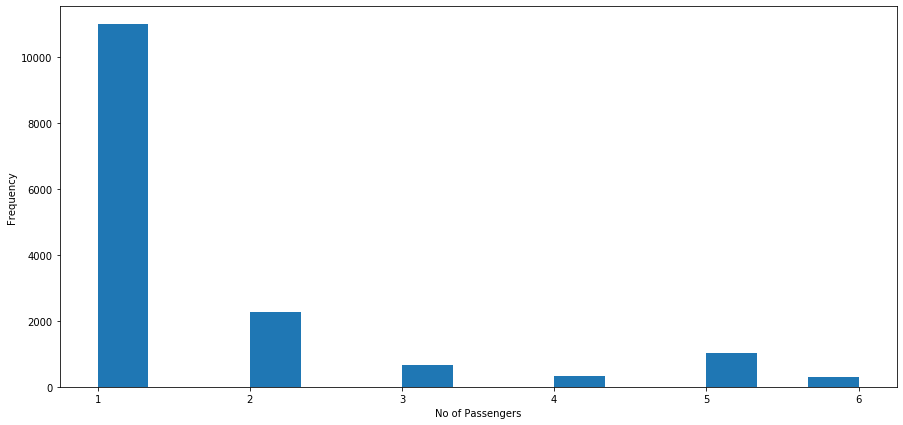

In [264]:
plt.figure(figsize = (15,7))
plt.hist(train['passenger_count'], bins=15)
plt.xlabel('No of Passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

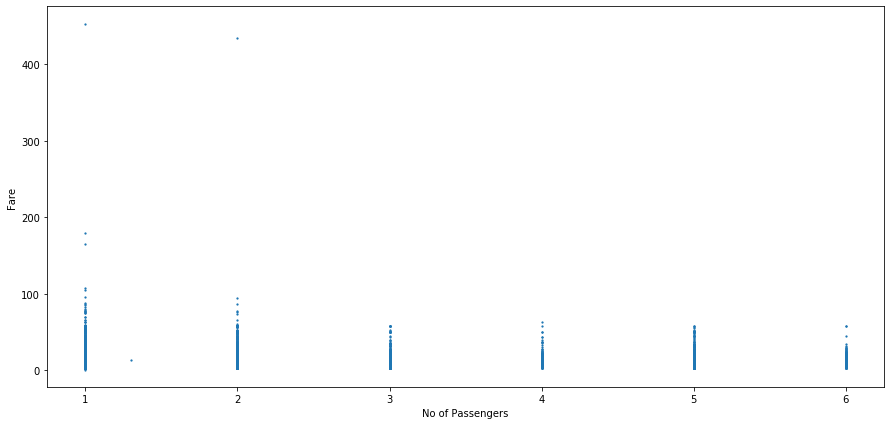

In [265]:
plt.figure(figsize = (15,7))
plt.scatter(x = train['passenger_count'], y = train['fare_amount'], s=1.5)
plt.xlabel('No of Passengers')
plt.ylabel('Fare')# I see that single passenger is most frequent travellers, and highest fare also seems to come from cabs which carry just the 1 passenger

In [266]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'],errors='coerce')

In [267]:
train.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [269]:
train['pickup_year'] = train['pickup_datetime'].dt.year
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_date'] = train['pickup_datetime'].dt.day
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_Dayofweek'] = train['pickup_datetime'].dt.dayofweek
train['pickup_minute'] = train['pickup_datetime'].dt.minute

In [270]:
train

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,17,0,26
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,16,1,52
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,0,3,35
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,4,5,30
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,7,1,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16061,10.9,2009-05-20 18:56:42+00:00,-73.994191,40.751138,-73.962769,40.769719,1.0,2009,5,20,18,2,56
16062,6.5,2014-12-12 07:41:00+00:00,-74.008820,40.718757,-73.998865,40.719987,1.0,2014,12,12,7,4,41
16063,16.1,2009-07-13 07:58:00+00:00,-73.981310,40.781695,-74.014392,40.715527,2.0,2009,7,13,7,0,58
16064,8.5,2009-11-11 11:19:07+00:00,-73.972507,40.753417,-73.979577,40.765495,1.0,2009,11,11,11,2,19


In [272]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1.0
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1.0
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1.0
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1.0
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1.0


In [273]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'],errors='coerce')

In [274]:
test['pickup_year'] = test['pickup_datetime'].dt.year
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_date'] = test['pickup_datetime'].dt.day
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_Dayofweek'] = test['pickup_datetime'].dt.dayofweek
test['pickup_minute'] = test['pickup_datetime'].dt.minute

In [275]:
#calculate the distance travelled by cab from the pickup latutude & longitude and dropoff latutude & longitude


In [276]:
#Does the pickup_datetime (Pickup Date & Time) affect the fare_amount (fare)?

In [277]:
train

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,17,0,26
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,16,1,52
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,0,3,35
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,4,5,30
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,7,1,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16061,10.9,2009-05-20 18:56:42+00:00,-73.994191,40.751138,-73.962769,40.769719,1.0,2009,5,20,18,2,56
16062,6.5,2014-12-12 07:41:00+00:00,-74.008820,40.718757,-73.998865,40.719987,1.0,2014,12,12,7,4,41
16063,16.1,2009-07-13 07:58:00+00:00,-73.981310,40.781695,-74.014392,40.715527,2.0,2009,7,13,7,0,58
16064,8.5,2009-11-11 11:19:07+00:00,-73.972507,40.753417,-73.979577,40.765495,1.0,2009,11,11,11,2,19


Text(0, 0.5, 'Fare')

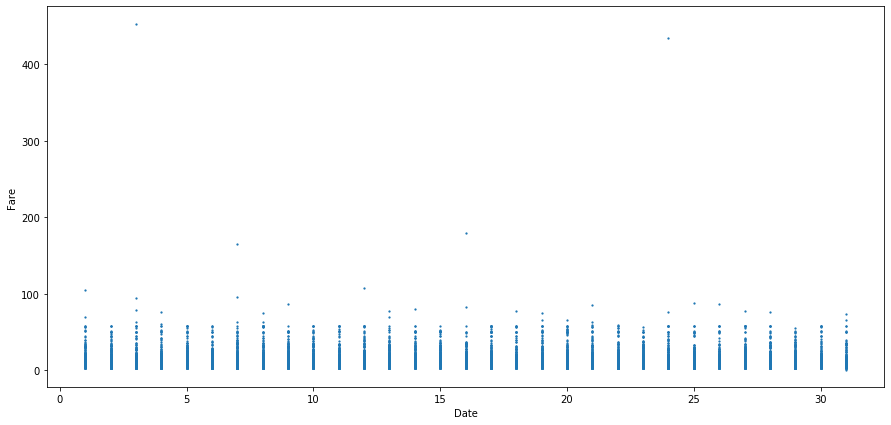

In [278]:
plt.figure(figsize = (15,7))
plt.scatter(x = train['pickup_date'], y = train['fare_amount'], s=1.5)
plt.xlabel('Date')#does the pickupdate of month affect the fare_amount
plt.ylabel('Fare')#the fare_amount throughout the month is seem to be uniform, with maximum fare received on th 3rd

Text(0, 0.5, 'Frequency')

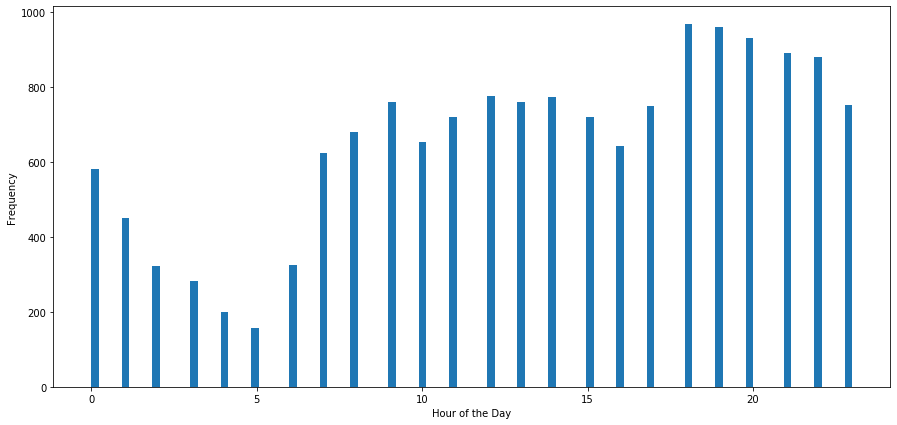

In [279]:
#does pickuptime of the day affect the fare_amount?
plt.figure(figsize = (15,7))
plt.hist(train['pickup_hour'], bins = 100)
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')#The time of the day plays an important role. The frequency of cab rides seem to be lowest at 5AM and the highest at 6PM.

Text(0, 0.5, 'Fare')

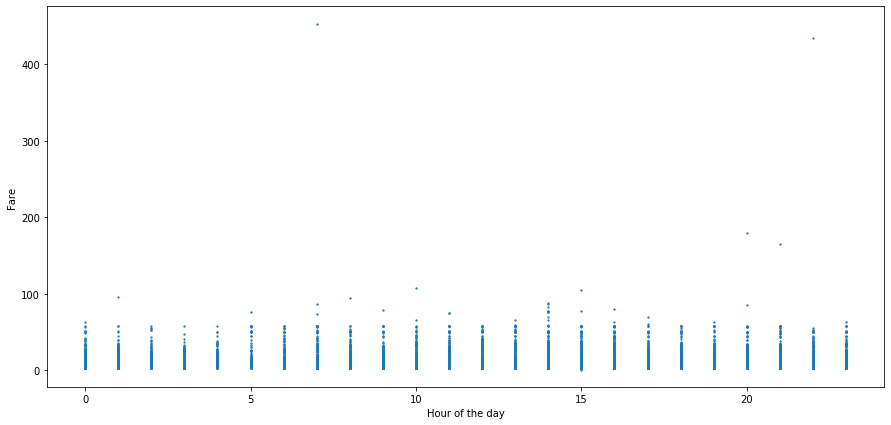

In [280]:
plt.figure(figsize = (15,7))
plt.scatter(x = train['pickup_hour'], y = train['fare_amount'], s =1.5)
plt.xlabel('Hour of the day')
plt.ylabel('Fare')#The fares, seem to be the high between 5AM to 10AM and 1PM to 4PM. Maybe people who leave early to avoid traffic and cover large distance

In [281]:
#Does the distance travelled affect the fare_amount (fare)?


In [282]:
def harvesine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for i in data: 
        R = 6371 #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
        
        delta_phi = np.radians(i[lat2] - i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
        
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi/2.0)**2 + np.cos(phi1) * np.cos(phi2)* np.sin(delta_lambda/2.0)**2
        
        #c = 2 * arctan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        
        #d = R * c
        d = (R * c) #distance in kilometers
        i['H_Distance'] = d
    return d

In [283]:
#haversine(θ) = sin²(θ/2)

#Eventually, the formual boils down to the following where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km) to include latitude and longitude coordinates (A and B in this case).

#a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)

#c = 2 * atan2( √a, √(1−a) )

#d = R ⋅ c

#d = Haversine distance

In [284]:
harvesine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0        2.323259
1        2.425353
2        0.618628
3        1.961033
4        5.387301
          ...    
9909     2.124874
9910     3.270969
9911    19.183942
9912     8.343486
9913     1.180825
Length: 9914, dtype: float64

In [285]:
train['H_Distance'].head(10)

0     1.030764
1     8.450134
2     1.389525
3     2.799270
4     1.999157
5     3.787239
6     1.555807
7     4.155444
9     2.849627
10    1.374577
Name: H_Distance, dtype: float64

In [286]:
train

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute,H_Distance
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,17,0,26,1.030764
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,16,1,52,8.450134
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,0,3,35,1.389525
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,4,5,30,2.799270
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,7,1,51,1.999157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16061,10.9,2009-05-20 18:56:42+00:00,-73.994191,40.751138,-73.962769,40.769719,1.0,2009,5,20,18,2,56,3.357490
16062,6.5,2014-12-12 07:41:00+00:00,-74.008820,40.718757,-73.998865,40.719987,1.0,2014,12,12,7,4,41,0.850044
16063,16.1,2009-07-13 07:58:00+00:00,-73.981310,40.781695,-74.014392,40.715527,2.0,2009,7,13,7,0,58,7.867638
16064,8.5,2009-11-11 11:19:07+00:00,-73.972507,40.753417,-73.979577,40.765495,1.0,2009,11,11,11,2,19,1.469105


In [287]:
train.sort_values(['H_Distance', 'fare_amount'],ascending = False)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute,H_Distance
10710,3.70,2011-02-11 21:46:09+00:00,-73.955411,39.604164,-73.955647,40.772837,1.0,2011,2,11,21,4,46,129.950482
14536,4.10,2011-04-03 12:16:46+00:00,-73.982155,40.775187,-73.976399,39.610030,1.0,2011,4,3,12,6,16,129.560455
11619,11.30,2011-05-27 21:47:44+00:00,-73.945106,39.603178,-73.976636,40.749643,1.0,2011,5,27,21,4,47,127.509261
12228,16.50,2011-04-26 23:18:56+00:00,-73.993360,40.721749,-73.977370,39.610604,2.0,2011,4,26,23,1,18,123.561157
5663,49.15,2009-02-25 07:05:05+00:00,-73.137393,41.366138,-74.000940,40.731723,1.0,2009,2,25,7,2,5,101.094619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8711,2.50,2013-01-02 09:33:21+00:00,-73.978626,40.744067,-73.978626,40.744067,1.0,2013,1,2,9,2,33,0.000000
9177,2.50,2010-12-06 11:48:34+00:00,-73.946993,40.744583,-73.946993,40.744583,3.0,2010,12,6,11,0,48,0.000000
9773,2.50,2013-03-29 18:45:53+00:00,-73.874439,40.773819,-73.874439,40.773819,1.0,2013,3,29,18,4,45,0.000000
10705,2.50,2013-09-13 16:14:28+00:00,-73.950813,40.771671,-73.950813,40.771671,1.0,2013,9,13,16,4,14,0.000000


Text(0, 0.5, 'Frequency')

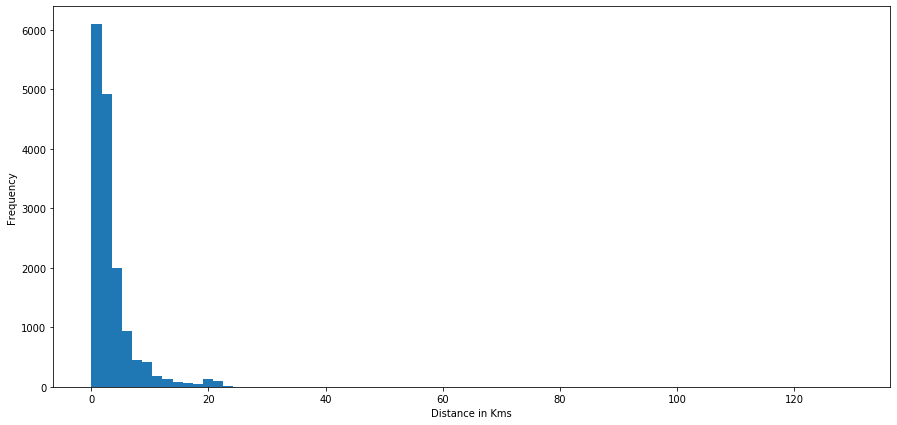

In [288]:
plt.figure(figsize = (15,7))
plt.hist(train['H_Distance'], bins=75)
plt.xlabel('Distance in Kms')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

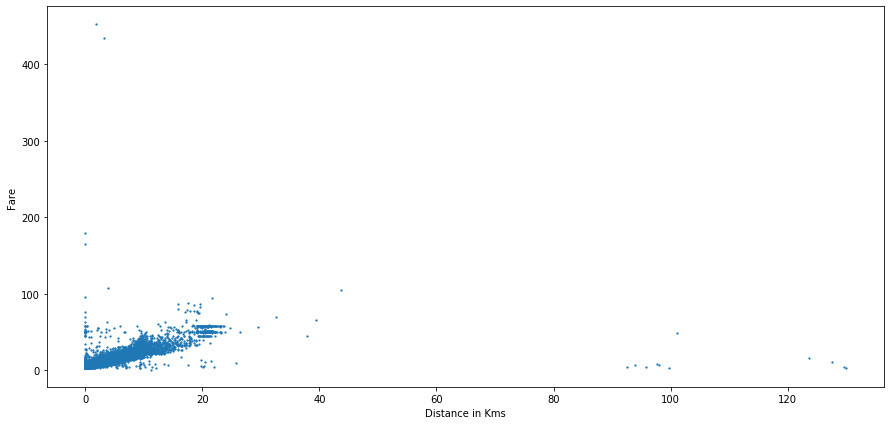

In [289]:
plt.figure(figsize = (15,7))
plt.scatter(x = train['H_Distance'], y = train['fare_amount'], s=1.5 )
plt.xlabel('Distance in Kms')
plt.ylabel('Fare')# as we see outliers here ater 50km we will drop them

In [290]:
train = train.drop(train[train['H_Distance']>50].index, axis =0) #11 observations dropped

In [291]:
train[train['H_Distance']==0]#The cab waited the whole time and passenger cancelled the trip after sometime. Thats the reason why the pickup and dropoff coordinates are same and maybe, passenger was charged for the waiting time.

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute,H_Distance
105,52.0,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1.0,2009,3,25,0,2,8,0.0
191,6.5,2014-01-08 21:55:58+00:00,-73.998488,40.726303,-73.998488,40.726303,1.0,2014,1,8,21,2,55,0.0
270,7.5,2012-08-25 01:53:42+00:00,-73.995892,40.746454,-73.995892,40.746454,1.0,2012,8,25,1,5,53,0.0
290,6.9,2009-12-14 12:33:00+00:00,-73.982432,40.745747,-73.982432,40.745747,1.0,2009,12,14,12,0,33,0.0
396,12.0,2014-03-12 18:12:44+00:00,-73.844904,40.736318,-73.844904,40.736318,1.0,2014,3,12,18,2,12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15738,8.5,2012-05-11 07:28:00+00:00,-73.937762,40.758157,-73.937762,40.758157,1.0,2012,5,11,7,4,28,0.0
15769,17.0,2012-12-21 20:35:18+00:00,-74.003743,40.756404,-74.003743,40.756404,1.0,2012,12,21,20,4,35,0.0
15869,6.9,2009-07-22 00:02:37+00:00,-73.941874,40.748985,-73.941874,40.748985,1.0,2009,7,22,0,2,2,0.0
15906,12.5,2011-11-20 12:58:00+00:00,-73.928838,40.616788,-73.928838,40.616788,2.0,2011,11,20,12,6,58,0.0


In [292]:
train = train.drop(train[train['H_Distance']==0].index, axis=0)

In [293]:
train.shape

(15404, 14)

In [294]:
test[test['H_Distance']==0]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute,H_Distance
121,2014-06-14 13:39:00+00:00,-73.980590,40.747682,-73.980590,40.747682,1.0,2014,6,14,13,5,39,0.0
279,2010-09-05 22:31:32+00:00,-74.047394,40.785789,-74.047394,40.785789,1.0,2010,9,5,22,6,31,0.0
318,2009-06-10 16:55:00+00:00,-73.985862,40.744027,-73.985862,40.744027,1.0,2009,6,10,16,2,55,0.0
417,2011-06-24 12:03:00+00:00,-73.964615,40.777620,-73.964615,40.777620,1.0,2011,6,24,12,4,3,0.0
423,2011-06-24 12:03:00+00:00,-73.955065,40.771505,-73.955065,40.771505,1.0,2011,6,24,12,4,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9478,2011-12-13 22:00:00+00:00,-73.946078,40.749467,-73.946078,40.749467,5.0,2011,12,13,22,1,0,0.0
9500,2014-07-21 18:19:00+00:00,-73.975767,40.752947,-73.975767,40.752947,5.0,2014,7,21,18,0,19,0.0
9563,2011-03-06 21:01:00+00:00,-73.990780,40.724202,-73.990780,40.724202,5.0,2011,3,6,21,6,1,0.0
9830,2014-07-21 18:19:00+00:00,-73.981425,40.773935,-73.981425,40.773935,6.0,2014,7,21,18,0,19,0.0


In [295]:
test = test.drop(test[test['H_Distance']==0].index, axis=0)

In [296]:
test.shape

(9829, 13)

# modelling and predicting

In [297]:
#Currently I am dealing with Regression Model So I am considering following algorithm models:
#Linear Regression
#Decision Tree
#Random Forest

In [339]:
#https://github.com/DishankBari/CarFarePrediction/blob/master/Care%20Fare%20Prediction%20Project%20Report%20-%20Dishank.pdf

In [298]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_year', 'pickup_month', 'pickup_date', 'pickup_hour',
       'pickup_Dayofweek', 'pickup_minute', 'H_Distance'],
      dtype='object')

In [299]:
test.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_year', 'pickup_month', 'pickup_date', 'pickup_hour',
       'pickup_Dayofweek', 'pickup_minute', 'H_Distance'],
      dtype='object')

In [300]:
#now we will be dropping datetime_pickup
train = train.drop(columns='pickup_datetime')
test = test.drop(columns='pickup_datetime')

In [301]:
X = train.drop('fare_amount', axis=1)# defining feature matrix


In [302]:
X

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute,H_Distance
0,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,17,0,26,1.030764
1,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,16,1,52,8.450134
2,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,0,3,35,1.389525
3,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,4,5,30,2.799270
4,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,7,1,51,1.999157
...,...,...,...,...,...,...,...,...,...,...,...,...
16061,-73.994191,40.751138,-73.962769,40.769719,1.0,2009,5,20,18,2,56,3.357490
16062,-74.008820,40.718757,-73.998865,40.719987,1.0,2014,12,12,7,4,41,0.850044
16063,-73.981310,40.781695,-74.014392,40.715527,2.0,2009,7,13,7,0,58,7.867638
16064,-73.972507,40.753417,-73.979577,40.765495,1.0,2009,11,11,11,2,19,1.469105


In [303]:
y = train.iloc[:,0].values

In [304]:
y

array([ 4.5, 16.9,  5.7, ..., 16.1,  8.5,  8.1])

In [305]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y =train_test_split(X,y,test_size=0.3)

In [306]:
from sklearn import linear_model
import statsmodels.api as sm

In [307]:
LR_model = linear_model.LinearRegression()

In [308]:
LR_model.fit(train_X,train_y)

LinearRegression()

In [309]:
LR_predict = LR_model.predict(test_X)

In [310]:
LR_predict

array([ 7.659747  ,  5.69107073,  2.82841118, ...,  6.80591701,
       11.10614483, 11.30437469])

In [311]:
#train the model using training dataset
model_LR = sm.OLS(train_y, train_X).fit()
predict_LR = model_LR.predict(test_X)
model_LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.777
Model:                            OLS   Adj. R-squared (uncentered):              0.776
Method:                 Least Squares   F-statistic:                              3121.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):                        0.00
Time:                        19:02:21   Log-Likelihood:                         -37000.
No. Observations:               10782   AIC:                                  7.402e+04
Df Residuals:                   10770   BIC:                                  7.411e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
pickup_longitude     12.5574      1.978      6.350      0.000       8.681      16.434
pickup_latitude      11.2283      2.736      4.104      0.000       5.866      16.591
dropoff_longitude     2.1422      1.908      1.122      0.262      -1.599       5.883
dropoff_latitude     -9.5298      2.434     -3.916      0.000     -14.300      -4.760
passenger_count       0.0263      0.057      0.462      0.644      -0.085       0.138
pickup_year           0.5078      0.037     13.626      0.000       0.435       0.581
pickup_month          0.0776      0.021      3.691      0.000       0.036       0.119
pickup_date          -0.0122      0.008     -1.466      0.143      -0.029       0.004
pickup_hour           0.0174      0.011      1.559      0.119      -0.004       0.039
pickup_Dayofweek     -0.0573      0.037     -1.556      0.120      -0.129       0.015
pickup_minute         0.0050      0.004      1.210      0.226      -0.003       0.013
H_Distance            2.2130      0.021    106.487      0.000       2.172       2.254
==============================================================================
Omnibus:                    30736.699   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2049437456.426
Skew:                          37.942   Prob(JB):                         0.00
Kurtosis:                    2137.514   Cond. No.                     9.24e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [312]:
#pickup_longitude, pickup_latitude, dropoff_latitude, year, month, hour, H_distance have small p-values, where as dropoff_longitude, passenger_count, date have a larger p-values
#Here I reject the null-hypothesis for pickup_longitude, pickup_latitude, dropoff_latitude, year, month, hour, H_distance
#* There is assicoation between these variables and fare_amount


#Fail to reject the null hypothesis for dropoff_longitude, passenger_count, date

#There is no association
#R-squared (0.848) means this model provides better fit for the given data

In [313]:
#here we used Error Metrics to evaluate the model

#Mean Absolute Error (MAE): is the mean of the absolute value of the errors: In [0,∞), the smaller the better

#Mean Squared Error (MSE): is the mean of the squared errors: In [0,∞), the smaller the better

#Mean Absolute Percent Error (MAPE): is the mean of the absolute percent value of the errors: In [0,1), the smaller the better

#Root Mean Squared Error (RMSE) :is the square root of the mean of the squared errors: In [0,∞), the smaller the bett

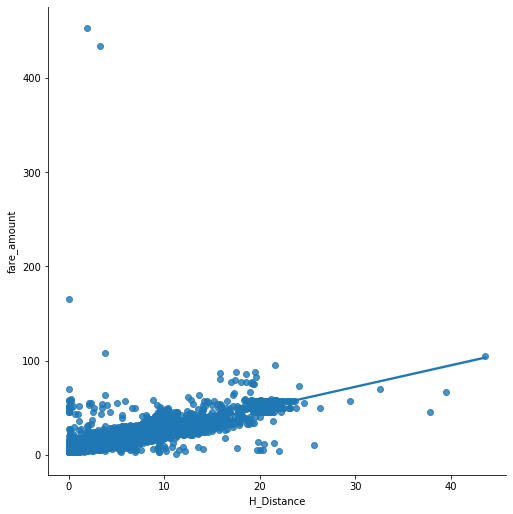

In [314]:
#plotting scatter pair plot H_Distance vs fare_amount
sns.pairplot(train, x_vars=['H_Distance'], y_vars='fare_amount', height = 7,kind='reg')

In [315]:
def MAPE(true_y, pred_y):
    mape = np.mean(np.abs(true_y-pred_y)/true_y)
    return mape

In [316]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# calculate MAE, MSE, MAPE, RMSE
print("MAE:",mean_absolute_error(test_y, predict_LR))
print("MSE:",mean_squared_error(test_y, predict_LR))
print("MAPE:",MAPE(test_y,predict_LR))
print("RMSE:",np.sqrt(mean_squared_error(test_y, predict_LR)))


MAE: 2.249378506273636
MSE: 17.091705457684373
MAPE: 0.21820251577913347
RMSE: 4.134211588402845


In [317]:
#DecisionTree


In [318]:
from sklearn.tree import DecisionTreeRegressor

In [319]:
model_DT = DecisionTreeRegressor(max_depth = 2).fit(train_X,train_y)
predict_DT = model_DT.predict(test_X)

In [320]:
print("MAE:",mean_absolute_error(test_y, predict_DT))
print("MSE:",mean_squared_error(test_y, predict_DT))
print("MAPE:",MAPE(test_y,predict_DT))
print("RMSE:",np.sqrt(mean_squared_error(test_y, predict_DT)))

MAE: 2.9318709030606707
MSE: 21.795879874177437
MAPE: 0.3172140511135726
RMSE: 4.668605774123302


In [321]:

from sklearn.ensemble import RandomForestRegressor

In [322]:
model_RF = RandomForestRegressor(n_estimators = 1000)

##train the model using training dataset
model_RF.fit(train_X, train_y)

RandomForestRegressor(n_estimators=1000)

In [323]:
predict_RF = model_RF.predict(test_X)

In [324]:
print("MAE:",mean_absolute_error(test_y, predict_RF))
print("MSE:",mean_squared_error(test_y, predict_RF))
print("MAPE:",MAPE(test_y,predict_RF))
print("RMSE:",np.sqrt(mean_squared_error(test_y, predict_RF)))

MAE: 2.1184436391172596
MSE: 36.2728738258244
MAPE: 0.22067218209486034
RMSE: 6.022696557674511


In [ ]:
MAPE for model evaluatiomn becasue, it calculate average absolute percent error for each time period minus actual values divided by actual values.
Random Forest Model has smallest error metrics i.e.

MAPE = 0.214435
So, for further analysis I am selecting Random Forest Model.

In [337]:
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_X)
validation_df_scaled = scaler.transform(test_X)
test_scaled = scaler.transform(test)

In [330]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

#adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [332]:
print('Input dimension: %s' % train_df_scaled.shape[1])
print('Features used: %s' % train_X.columns)

Input dimension: 12
Features used: Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'pickup_year', 'pickup_month',
       'pickup_date', 'pickup_hour', 'pickup_Dayofweek', 'pickup_minute',
       'H_Distance'],
      dtype='object')


In [333]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               3328      
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 32)               

In [338]:
history = model.fit(x=train_df_scaled, y=train_X['fare_amount'].values, batch_size=256, epochs=50, 
                    verbose=1, validation_data=(validation_df_scaled, validation_labels), 
                    shuffle=True)

KeyError: 'fare_amount'

In [336]:
train

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute,H_Distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,17,0,26,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,16,1,52,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,0,3,35,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,4,5,30,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,7,1,51,1.999157
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16061,10.9,-73.994191,40.751138,-73.962769,40.769719,1.0,2009,5,20,18,2,56,3.357490
16062,6.5,-74.008820,40.718757,-73.998865,40.719987,1.0,2014,12,12,7,4,41,0.850044
16063,16.1,-73.981310,40.781695,-74.014392,40.715527,2.0,2009,7,13,7,0,58,7.867638
16064,8.5,-73.972507,40.753417,-73.979577,40.765495,1.0,2009,11,11,11,2,19,1.469105


In [ ]:
plot_loss_accuracy(history)
prediction = model.predict(test_scaled, batch_size=128, verbose=1)